In [17]:
from pathlib import Path
import glob
import matplotlib.pyplot as plt
from typing import List, Dict
import numpy as np
import pandas as pd
from skimage.measure._regionprops import RegionProperties
from skimage.measure import regionprops
import uuid
import btrack
import os.path

from livecell_tracker import core
from livecell_tracker.core import datasets, single_cell, utils, io_utils
from livecell_tracker.segment.utils import prep_scs_from_mask_dataset
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)

from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.core.sc_key_manager import SingleCellMetaKeyManager as SCKM

Loading single cells from existing mask files

In [18]:
dataset_dir_path = Path("../datasets/test_data_STAV-A549/DIC_data")

mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")
mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
time2url = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*_DIC.tif")))))
time2url = {i: path for i, path in enumerate(time2url)}
dic_dataset = LiveCellImageDataset(time2url=time2url, ext="tif")
single_cells = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

3 png img file paths loaded;


100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


In [19]:
single_cells[0]

SingleCellStatic(id=bcc7ad2f-b74d-462f-9fb1-5247ab68a7c6, timeframe=1, bbox=[ 143  981  207 1047])

Prepare feature to create btrack object

In [20]:
def extract_features(single_cell: SingleCellStatic, features: List[str]) -> Dict[str, float]:
    """Extract selected features from a SingleCellStatic instance and return as a dictionary."""
    feature_dict = {}
    single_cell.update_regionprops()
    for feature in features:
        # Call the corresponding method for each feature
        feature_dict[feature] = getattr(single_cell.regionprops, feature)
    return feature_dict


In [21]:
FEATURES = [
    "area", 
    "major_axis_length", 
    "minor_axis_length", 
    "orientation", 
    "solidity"
]
feature_dict = extract_features(single_cells[0], FEATURES)
feature_dict

{'area': 2879.0,
 'major_axis_length': 75.79599700793588,
 'minor_axis_length': 48.45575023025144,
 'orientation': 0.7852983622883078,
 'solidity': 0.9762631400474737}

create btrack objects (with properties) from the SingleCellStatic

In [22]:
from btrack.btypes import PyTrackObject
from btrack import constants

btarck_objects = []
single_cell_dict = {}
counter = 0

for single_cell in single_cells:
    # Update regionprops
    single_cell.update_regionprops()
    # Obtain the centroid coordinates
    centroid = single_cell.get_center(crop=True) + np.array([single_cell.bbox[0],single_cell.bbox[2]])
    
    # Obtain the time frame
    time = single_cell.timeframe
    # Obtain the cell's area and other properties
    area = single_cell.regionprops.area

    # Create a PyTrackObject
    obj = PyTrackObject()
    obj.ID = counter
    obj.x = float(centroid[1])   # Ensure x and y are floats
    obj.y = float(centroid[0])
    obj.t = int(time)
    obj.dummy = False
    obj.states = 1   # Setting the number of states to 1 for simplicity
    obj.label = constants.States.NULL.value  # The label is the state of the object
    obj.n_features = len(FEATURES)  # Number of features
    feature_dict = extract_features(single_cell, FEATURES)
    obj.properties = feature_dict   # Ensure 'area' is float
    
    btarck_objects.append(obj)
    single_cell_dict[counter] = single_cell
    
    counter += 1


In [23]:
btarck_objects[0]

,ID,x,y,z,t,dummy,states,label,area,major_axis_length,minor_axis_length,orientation,solidity
0,0,239.408128,173.553664,0.0,1,False,1,5,2879.0,75.795997,48.45575,0.785298,0.976263


In [24]:
TRACKING_UPDATES = [
  "motion",
  "visual",
]

In [25]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as btracker:
    # configure the tracker using a config file **
    btracker.configure('./config/cell_config.json')  

    # set up the features to use as a list ***
    btracker.features = FEATURES

    # append the objects to be tracked
    btracker.append(btarck_objects)

    # tell the tracker to use certain information while
    # performing tracking ****
    btracker.track(tracking_updates=TRACKING_UPDATES)

    # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
    # You might want to adjust the dimensions (1200, 1600) to match your images
    btracker.volume = ((0, 1200), (0, 1600))

    # track them 
    btracker.track(step_size=100)

    # generate hypotheses and run the global optimizer ****
    btracker.optimize()

    # store the data in an HDF5 file
    btracker.export('./output/tracks1.h5', obj_type='obj_type_1')

    # get the tracks as a python list
    tracks = btracker.tracks

    # get the data in a format for napari
    data, properties, graph = btracker.to_napari()


[INFO][2023/06/11 02:10:38 PM] Loaded btrack: C:\Users\13290\AppData\Local\Programs\Python\Python39\Lib\site-packages\btrack\libs\libtracker.DLL
[INFO][2023/06/11 02:10:38 PM] Starting BayesianTracker session
[INFO][2023/06/11 02:10:38 PM] Loading configuration file: ./config/cell_config.json
[INFO][2023/06/11 02:10:38 PM] Objects are of type: <class 'list'>
[INFO][2023/06/11 02:10:38 PM] Starting tracking... 
[INFO][2023/06/11 02:10:38 PM] Update using: ['VISUAL', 'MOTION']
[INFO][2023/06/11 02:10:38 PM] SUCCESS.
[INFO][2023/06/11 02:10:38 PM]  - Found 15 tracks in 3 frames (in 0.0s)
[INFO][2023/06/11 02:10:38 PM]  - Inserted 0 dummy objects to fill tracking gaps
[INFO][2023/06/11 02:10:38 PM] Starting tracking... 
[INFO][2023/06/11 02:10:38 PM] Update using: ['VISUAL', 'MOTION']
[INFO][2023/06/11 02:10:38 PM] SUCCESS.
[INFO][2023/06/11 02:10:38 PM]  - Found 19 tracks in 3 frames (in 0.0s)
[INFO][2023/06/11 02:10:38 PM]  - Inserted 0 dummy objects to fill tracking gaps
[INFO][2023/06/

In [26]:
s_cell = tracks[1]
s_cell

,ID,t,x,y,z,parent,root,state,generation,dummy,solidity,major_axis_length,orientation,minor_axis_length,area
0,13,0,239.473579,173.949485,0.0,13,13,5,0,False,0.974733,75.059065,0.777871,51.109228,3009.0
1,13,1,239.408128,173.553664,0.0,13,13,5,0,False,0.976263,75.795997,0.785298,48.455750,2879.0
2,13,2,238.888354,172.403593,0.0,13,13,5,0,False,0.977116,77.570565,0.877814,51.215930,3117.0


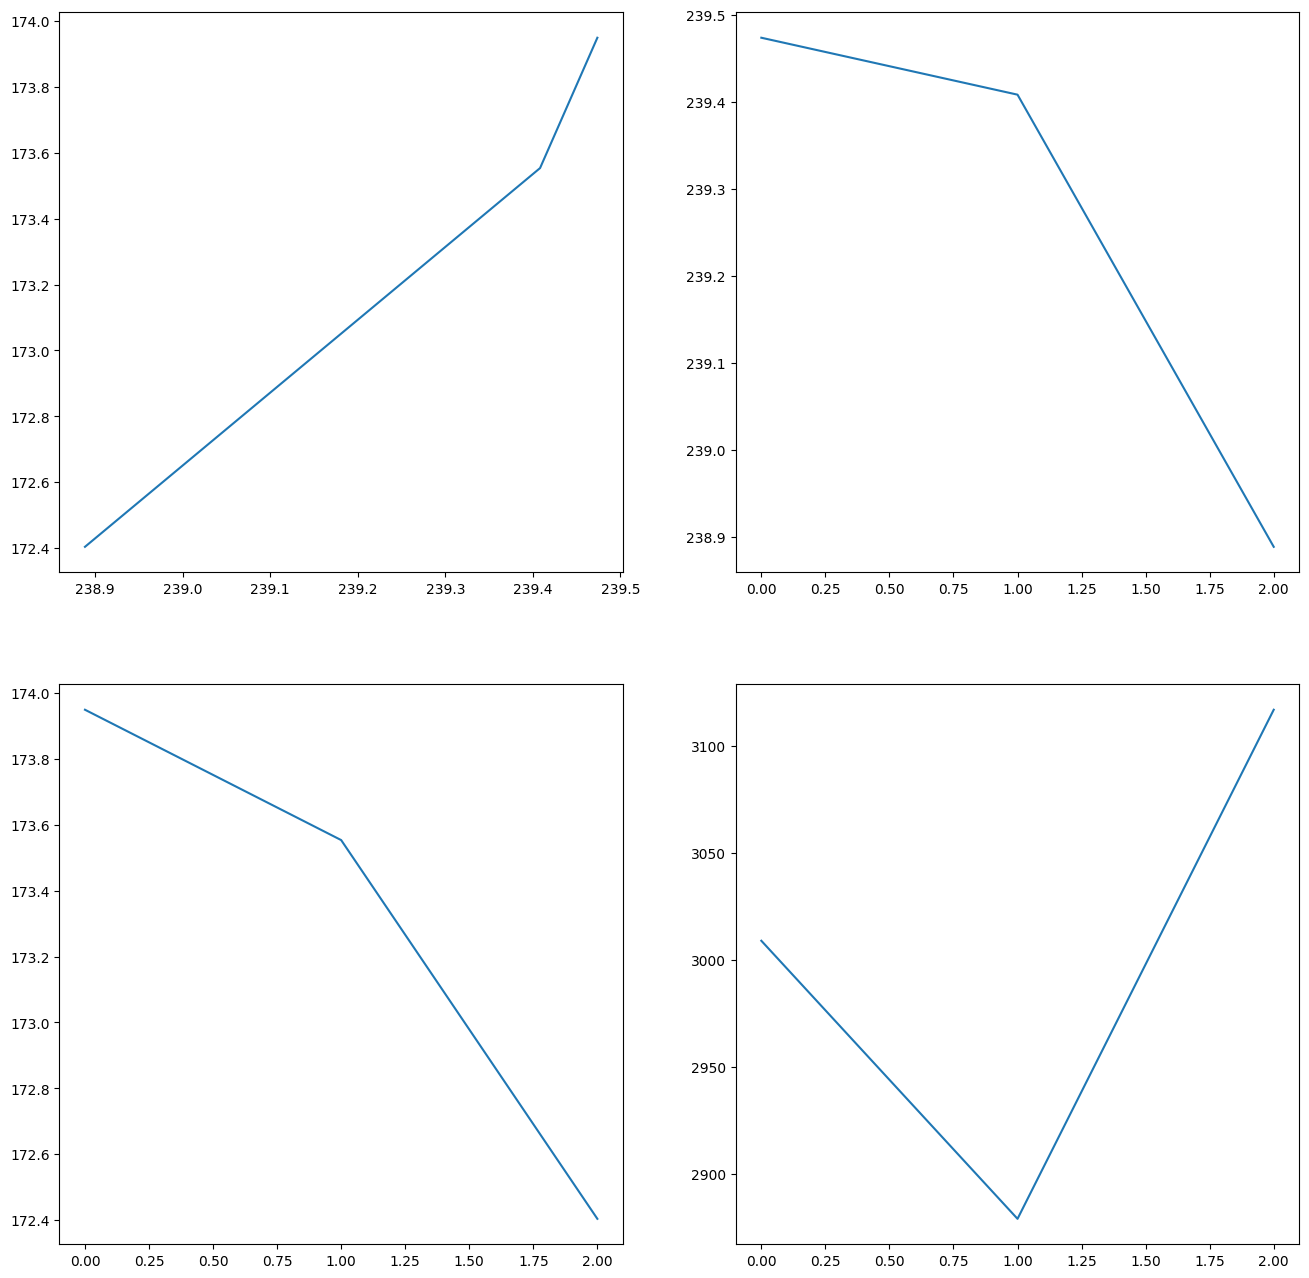

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
ax1.plot(s_cell.x, s_cell.y)
ax2.plot(s_cell.t, s_cell.x)
ax3.plot(s_cell.t, s_cell.y)
ax4.plot(s_cell.t, s_cell["area"])
plt.show()

In [28]:
from livecell_tracker.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
# add btrack tracks to our SingleCellTrajectoryCollection
traj_collection = SingleCellTrajectoryCollection()

for track in tracks:
    # use track index (time) to get each frame's object
    time_to_sc = {t: single_cell_dict[obj_id] for t, obj_id in zip(track.t, track.refs)}


    traj = SingleCellTrajectory(
        track_id=track.ID, 
        timeframe_to_single_cell=time_to_sc,
        img_dataset=LiveCellImageDataset(dataset_dir_path, time2url=time2url, ext="tif"),  
        mask_dataset=LiveCellImageDataset(mask_dataset_path, ext="png") 
    )
    print(traj.timeframe_to_single_cell)
    traj_collection.add_trajectory(traj)


3 png img file paths loaded;
{0: SingleCellStatic(id=19a64021-3150-499a-a6b7-7c4832b750d2, timeframe=0, bbox=[ 885 1249 1024 1332]), 1: SingleCellStatic(id=d39dd27d-24f4-4eac-9431-14e152c64e0a, timeframe=1, bbox=[ 886 1245 1031 1328])}
3 png img file paths loaded;
{0: SingleCellStatic(id=a5bc3054-28c4-403e-b071-b1edbcde4343, timeframe=0, bbox=[ 143  978  207 1044]), 1: SingleCellStatic(id=bcc7ad2f-b74d-462f-9fb1-5247ab68a7c6, timeframe=1, bbox=[ 143  981  207 1047]), 2: SingleCellStatic(id=2d95f188-8875-420b-a5b9-f71f5c6068eb, timeframe=2, bbox=[ 141  981  205 1051])}
3 png img file paths loaded;
{0: SingleCellStatic(id=6152885a-fab3-4cfa-a79a-100f02b1476c, timeframe=0, bbox=[ 208 1149  334 1315])}
3 png img file paths loaded;
{0: SingleCellStatic(id=508bfc28-a7ee-41a9-8ab1-fb38c4d411e6, timeframe=0, bbox=[ 400 1158  479 1269]), 1: SingleCellStatic(id=a1af6963-778a-4cb5-8e12-ece45753ee46, timeframe=1, bbox=[ 401 1154  483 1268]), 2: SingleCellStatic(id=3f33564d-4fdd-49c2-9fed-5e6a7648d

<Axes: xlabel='Trajectory Length', ylabel='count'>

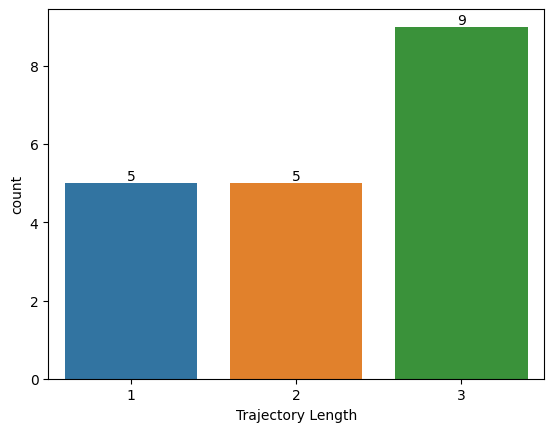

In [29]:
traj_collection.histogram_traj_length()

In [30]:
import napari
from livecell_tracker.core.napari_visualizer import NapariVisualizer
from livecell_tracker.core.sct_operator import SctOperator, create_sct_napari_ui

viewer = napari.view_image(dic_dataset.to_dask(), name="dic_image", cache=True)
# the track data from the tracker
viewer.add_tracks(
    data, 
    properties=properties, 
    graph=graph, 
    name="Tracks", 
    blending="translucent",
    visible=True,
)
shape_layer = NapariVisualizer.gen_trajectories_shapes(traj_collection, viewer, contour_sample_num=20)
shape_layer.mode = "select"

This is the end of btrack pipeline

In [31]:
from livecell_tracker.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
def track_cells(self, single_cells: List[SingleCellStatic], config_path: str, volume: tuple, output_path: str = '/path/to/tracks.h5'):
        """create btrack objects (with properties) from the segmentation data"""
        objects = []
        single_cell_dict = {}
        for single_cell in single_cells:
            single_cell.update_regionprops
            # obtain the centroid coordinates
            centroid = single_cell.get_center()
            # obtain the time frame
            time = single_cell.timeframe
            # obtain the cell's area and other properties
            area = single_cell.regionprops.area
            # create a btrack object
            obj = btrack.Object(ID=int(single_cell.id), x=centroid[1], y=centroid[0], t=time, area=area)
            objects.append(obj)
            single_cell_dict[single_cell.id] = single_cell

        # initialise a tracker session using a context manager
        with btrack.BayesianTracker() as tracker:
            # configure the tracker using a config file
            tracker.configure(config_path)

            # append the objects to be tracked
            tracker.append(objects)

            # set the volume
            tracker.volume = volume

            # track them (in interactive mode)
            tracker.track_interactive(step_size=100)

            # generate hypotheses and run the global optimizer
            tracker.optimize()

            # store the data in an HDF5 file
            tracker.export(output_path, obj_type='obj_type_1')

            # get the tracks as a python list
            tracks = tracker.tracks

        # add btrack tracks to our SingleCellTrajectoryCollection
        for track in tracks:
            trajectory_cells = {}
            for t in track.t:
                single_cell = single_cell_dict[track.ID]
                if single_cell.timeframe == t:
                    trajectory_cells[t] = single_cell
            traj = SingleCellTrajectory(
                track_id=track.ID, 
                timeframe_to_single_cell=trajectory_cells,
                img_dataset=LiveCellImageDataset(),  
                mask_dataset=LiveCellImageDataset() 
            )
            self.add_trajectory(traj)



In [32]:
import json
import numpy as np
from livecell_tracker.core.io_utils import LiveCellEncoder

numpyArrayOne = np.array([[11, 22, 33], [44, 55, 66], [77, 88, 99]])

# Serialization
numpyData = {"array": numpyArrayOne}
encodedNumpyData = json.dumps(numpyData, cls=LiveCellEncoder)  # use dump() to write array into file
print("Printing JSON serialized NumPy array")
print(encodedNumpyData)

Printing JSON serialized NumPy array
{"array": [[11, 22, 33], [44, 55, 66], [77, 88, 99]]}
